<a target="_blank" href="https://colab.research.google.com/github/ArtificialIntelligenceToolkit/aitk/blob/master/notebooks/MazeSearch.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Maze Search

Try to reproduce the maze search task in Lehman and Stanley's paper *Abandoning Objectives: Evolution through the Search for Novelty Alone*.  

There is a beacon that the robot is trying to reach (represented by a blue circle in the world).  The signal from the beacon is not blocked by walls. The robot is equipped with a compass sensor that indicates one of four possible directions where the beacon is located relative to the robot. The robot is also equipped with 6 range sensors that are more concentrated on its front end.

The robot has a total of 10 sensors.

In [ ]:
%pip install aitk --upgrade --quiet

In [1]:
from aitk.robots import World, Scribbler, Beacon, Compass, RangeSensor

In [2]:
world = World(200,200)
world.add_wall("black",0,50,125,55)
world.add_wall("black",65,50,70,150)
world.add_wall("black",65,150,125,155)
world.add_wall("black",125,100,200,105)
world.add_beacon(25, 25, 0)
world.watch()

Random seed set to: 2629030


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

In [3]:
robot = Scribbler(25, 175, 89)
robot.add_device(Compass())
robot.add_device_ring(RangeSensor,8,-90,90,5,max=40,width=0)
robot.add_device(RangeSensor(position=(-8,0),a=180,max=40,width=0))

In [4]:
world.add_robot(robot)

## Evolving a robot controller

We will use a Genetic Algorithm to evolve a neural network controller for the robot.  To evaluate the fitness of each network we will allow it to control the robot for a fixed amount of time, and then record its ending point in the world

We will use Novelty Search to assign each ending point a score.  Ending points that are close in distance to previously seen ending points will be given low scores, while ending points that reach new territory in the world will be given high scores.  


In [5]:
from aitk.algorithms import GeneticAlgorithm, NoveltySearch
from aitk.networks import SimpleNetwork
from aitk.robots.utils import distance
import random

In [19]:
class NoveltyGA(GeneticAlgorithm):
    def __init__(self, popsize, world, robot, sensors=10):
        self.novelty_search = NoveltySearch(
            k=15, 
            limit=100, 
            threshold=0.25,
            max_dist=distance((0,0),(200,200)),
        )
        self.show = False
        self.sensors = sensors
        self.world = world
        self.robot = robot
        self.network = self.build_model()
        # Length of a chromosome:
        length = len(self.network.get_weights(flat=True))
        super().__init__(length, popsize)
    def make_random_gene(self):
        return 2 - random.random() * 4 
    def mutate_gene(self, gene):
        return gene + (0.5 - random.random())
    def fitness(self, chromosome, index=None, seconds=60, interrupt=True, real_time=False,
                show=False, show_progress=False, quiet=True):
        """During search, fitness is based on novelty"""
        self.show = show
        self.network.set_weights(chromosome)
        self.robot.set_pose(25,175,89)
        self.world.seconds(seconds, self.controller, interrupt=interrupt, 
                           real_time=real_time, show=show, show_progress=show_progress, 
                           quiet=quiet)
        x, y, a = self.robot.get_pose()
        score = self.novelty_search.check_archive([(x, y)],chromosome)
        return score
    def test_chromo(self, chromosome, seconds=60):
        """During testing, see how well behavior covers grid"""
        self.network.set_weights(chromosome)
        self.robot.set_pose(25,175,89)
        self.world.seconds(seconds, self.controller, interrupt=True, 
                           real_time=False, show=True, show_progress=True, 
                           quiet=True)
        r_x, r_y, r_a = self.robot.get_pose()
        b_x, b_y, = self.world.beacon.get_position()
        return distance((r_x,r_y), (b_x, b_y))

In [7]:
class NoveltyGA(NoveltyGA):        
    def build_model(self):
        return SimpleNetwork(
            self.sensors,
            4,
            2,
            activation="sigmoid"
        )
    def controller(self, world):
        sensors = self.get_sensors()
        output = self.get_move(sensors)
        self.robot.move(output[0], output[1])
        if self.robot.stalled:
            return True
    def get_sensors(self):
        compass = robot['compass'].values
        ranges = [1-robot[i].get_reading() for i in range(1,7)]
        return compass+ranges
    def get_move(self, sensors):
        # Propagate takes a single pattern:
        output = self.network.propagate(
            sensors, show=self.show)
        # Scale the output in [-1, 1]
        return 1 - output * 2 

In [8]:
ga = NoveltyGA(30, world, robot)

Genetic algorithm
  Chromosome length: 54
  Population size: 30


### Checkpoint 1

Why is the chromosome length 54?

Answer: There are 10x4 weights from input to hidden, plus 4x2 weights from hidden to output, and all non-input units have a bias, so 6 of those: 40+8+6 is 54.

In [9]:
chromosome = ga.make_random_chromosome()
ga.fitness(chromosome, seconds=10, real_time=False, show=True)

1.0

In [10]:
chromosome = ga.make_random_chromosome()
ga.fitness(chromosome, seconds=10, real_time=False, show=True)

0.2004227965233836

In [15]:
%%time
bestFound = ga.evolve(
    generations=10, 
    crossover_rate=0.0, 
    mutation_rate=0.6, 
    elite_percent=0, 
    seconds=60,
    show=False,
) 

  Maximum number of generations: 10
  Crossover rate: 0.0
  Mutation rate: 0.6
  Elite percentage 0
  Elite count: 0
Generation    0 Best fitness 0.27
Generation    1 Best fitness 0.40
Generation    2 Best fitness 0.40
Generation    3 Best fitness 0.45
Generation    4 Best fitness 0.45
Generation    5 Best fitness 0.45
Generation    6 Best fitness 0.45
Generation    7 Best fitness 0.45
Generation    8 Best fitness 0.45
Generation    9 Best fitness 0.45
Generation   10 Best fitness 0.45
Max generations reached
CPU times: user 3min 19s, sys: 498 ms, total: 3min 20s
Wall time: 3min 20s


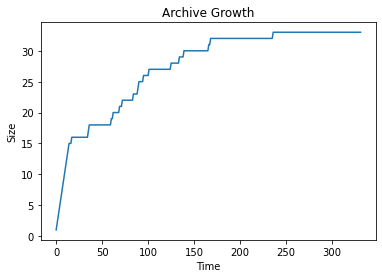

In [16]:
ga.novelty_search.plot_growth()

In [27]:
archive = ga.novelty_search.archive
end_points = []
for i in range(len(archive)):
    end_points.append(archive[i][0][0])

In [28]:
end_points

[(84.41040876605078, 190.69665797491143),
 (28.352946324537577, 182.26429804908838),
 (32.202354914181264, 190.16991644538038),
 (21.98518749311637, 190.1504959060541),
 (54.95419332045088, 153.05389967826807),
 (24.869458384413004, 176.69497577762445),
 (29.974317434903643, 190.77169539786055),
 (9.592136306916933, 179.41202378693856),
 (28.35965928924027, 189.415128854549),
 (41.15621635676185, 176.869114968029),
 (22.61410558898892, 189.8236056019716),
 (63.26597742812399, 162.94685710125628),
 (27.59072782779972, 189.97347294651632),
 (14.810377686345767, 189.70223989468295),
 (15.358367445235388, 190.55041215189087),
 (15.403049454173622, 110.16322476461777),
 (27.676736493203514, 65.33453913182197),
 (109.07346544985572, 180.25403404026568),
 (53.940547684326106, 71.53629341114893),
 (128.05314544497023, 163.7608644308619),
 (126.88473539373354, 162.86335038403476),
 (54.230206217085794, 77.30122966614312),
 (144.9225273106187, 169.76016777250084),
 (27.365876927672687, 77.368755

## Plot the end points on the world